In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, auc, roc_curve, accuracy_score, roc_auc_score

/Users/adsherman/miniconda2/envs/tZqAnalysis/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Plotting method definitions -- come back to read these later

In [2]:
def PlotTemplate(train_DF, test_DF, y_score_train, y_score_test, norm=True, ax=None):
    """ Using the source DataFrames and the score Series, plot the template 
        histograms for the training and testing sets
    """
    
    do_plot=False
    if ax == None:
        plt.clf()
        fig, ax = plt.subplots()
        do_plot=True

    ax.hist(y_score_test[test_DF["isSignal"] == 0], 
             weights=test_DF["weight"][test_DF["isSignal"] == 0] / (1.0 if not norm else sum(test_DF["weight"][test_DF["isSignal"] == 0])), 
             bins=10, range=(0,1), color="red", histtype="step", ls="-", label="test bkg")
    ax.hist(y_score_test[test_DF["isSignal"] == 1], 
             weights=test_DF["weight"][test_DF["isSignal"] == 1] / (1.0 if not norm else sum(test_DF["weight"][test_DF["isSignal"] == 1])), 
             bins=10, range=(0,1), color="blue", histtype="step", ls="-", label="test sig")
    ax.hist(y_score_train[train_DF["isSignal"] == 0], 
             weights=train_DF["weight"][train_DF["isSignal"] == 0] / (1.0 if not norm else sum(train_DF["weight"][train_DF["isSignal"] == 0])), 
             bins=10, range=(0,1), color="red", histtype="step", ls="--", label="train bkg")
    ax.hist(y_score_train[train_DF["isSignal"] == 1], 
             weights=train_DF["weight"][train_DF["isSignal"] == 1] / (1.0 if not norm else sum(train_DF["weight"][train_DF["isSignal"] == 1])), 
             bins=10, range=(0,1), color="blue", histtype="step", ls="--", label="train sig")
    ax.legend(loc="upper center")
    ax.set_title("%sBDT Score" % ("Normalized " if norm else ""))
    ax.set_xlabel("BDT score")
    ax.set_ylabel("Events" if not norm else "Fraction of Events")
    
    if do_plot:
        plt.show()


# Keep going

In [3]:
def PlotROC(train_DF, test_DF, y_score_train, y_score_test, ax=None):
    """ Compute ROC curve and ROC area for each class, and plot.
    """
    
    do_plot=False
    if ax == None:
        plt.clf()
        fig, ax = plt.subplots()
        do_plot=True

    fpr = {"test": {}, "train": {}}
    tpr = {"test": {}, "train": {}}
    roc_auc = {"test": {}, "train": {}}
    
    fpr["test"], tpr["test"], _ = roc_curve(test_DF["isSignal"], 
                                            y_score_test,
                                            sample_weight=test_DF["weight"])
    fpr["train"], tpr["train"], _ = roc_curve(train_DF["isSignal"], 
                                              y_score_train,
                                              sample_weight=train_DF["weight"])

    try:
        roc_auc["test"] = auc(fpr["test"], tpr["test"])
        roc_auc["train"] = auc(fpr["train"], tpr["train"])
    except:
        # print "Bug in old version of sklearn. Attempting to bypass. ROC AUC may be slightly incorrect."
        fpr["test"], tpr["test"] = zip(*sorted(zip(fpr["test"], tpr["test"])))
        fpr["train"], tpr["train"] = zip(*sorted(zip(fpr["train"], tpr["train"])))        
        roc_auc["test"] = auc(fpr["test"], tpr["test"])
        roc_auc["train"] = auc(fpr["train"], tpr["train"])

    ax.plot(fpr["test"], tpr["test"], color='darkblue',
             lw=2, label='test ROC AUC = %0.2f' % roc_auc["test"])
    ax.plot(fpr["train"], tpr["train"], color='darkorange',
             lw=2, label='train ROC AUC = %0.2f' % roc_auc["train"])    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")
    
    if do_plot:
        plt.show()        

In [4]:
def PlotROCTemplate(train_DF, test_DF, y_score_train, y_score_test):

    plt.clf()
    fig, axs = plt.subplots(1,2,figsize=(16,6))
    PlotTemplate(train_DF, test_DF, y_score_train, y_score_test, ax=axs[0])
    PlotROC(train_DF, test_DF, y_score_train, y_score_test, ax=axs[1])
    plt.show()

# Almost there

In [5]:
def PlotBehavior(x, results_train, results_test, xw=7, yw=4, plot_err=True, plot_vertical=False):
    """ If given a set of results swept over some hyperparameter, plot
    """
    
    to_plot = results_test.keys()
    
    plt.clf()
    if plot_vertical:
        fig, axs = plt.subplots(len(to_plot), 1, figsize=(xw*len(to_plot), yw))
    else:
        fig, axs = plt.subplots(1, len(to_plot), figsize=(xw*len(to_plot), yw))
    
    for i, var in enumerate(to_plot):
        
        axs[i].plot(x, results_test[var][:,0], color="darkblue", label="test")
        axs[i].plot(x, results_train[var][:,0],color="darkorange", label="train")
        if plot_err:
            axs[i].fill_between(x, results_test[var][:,0] + results_test[var][:,1], 
                            results_test[var][:,0] - results_test[var][:,1],
                            color="darkblue", label="test", alpha=0.3)
            axs[i].fill_between(x, results_train[var][:,0] + results_train[var][:,1], 
                            results_train[var][:,0] - results_train[var][:,1],
                            color="darkorange", label="train", alpha=0.3)    
        axs[i].set_title(var)
        axs[i].legend(loc="best")
        axs[i].set_xlabel("Number of Estimators")
        axs[i].set_ylabel(var)
    plt.show()

# !!! Start here !!!

First we must import our ROOT file. To do so, its nice to not have to use ROOT, so we will use uproot to convert some TTrees into pandas DataFrames


In [6]:
# Here is our file
my_file_path = "./tmva_class_example.root"

# Let's see at what trees it has
print uproot.open(my_file_path).keys()

['TreeS;1', 'TreeB;1']


Check what these keys give us

In [7]:
print(uproot.open(my_file_path)["TreeS"])
print(uproot.open(my_file_path)["TreeB"])

<TTree 'TreeS' at 0x00011c82f310>
<TTree 'TreeB' at 0x00011c86a250>


These are basically TTrees, so lets also look at the branches, stored as keys

In [8]:
print(uproot.open(my_file_path)["TreeS"].keys())
print(uproot.open(my_file_path)["TreeB"].keys())

['var1', 'var2', 'var3', 'var4']
['var1', 'var2', 'var3', 'var4', 'weight']


Lets see what they look like once processed into DataFrames

In [9]:
uproot.open(my_file_path)["TreeS"].pandas.df()[:5]

,var1,var2,var3,var4
0,-1.143611,-0.822373,-0.495426,-0.629427
1,2.143443,-0.018923,0.267030,1.267493
2,-0.443913,0.486827,0.139535,0.611483
3,0.281100,-0.347094,-0.240525,0.347208
4,0.604006,0.151232,0.964091,1.227711


In [10]:
uproot.open(my_file_path)["TreeB"].pandas.df()[:5]

,var1,var2,var3,var4,weight
0,-2.763987,-1.494146,-1.616673,-2.917889,0.106761
1,-0.700133,-1.344608,-0.822912,-1.393981,0.892978
2,3.407164,1.996978,2.607432,3.464603,0.001675
3,-3.178998,-3.001599,-3.545788,-4.120248,0.005029
4,0.966825,0.987334,1.110154,1.661289,0.175052


TreeS doesn't seem to have sample weights, although TreeB does, so we will append an arbitrary (1) event weight to TreeS's DataFrame, to each row.
Additionally, we will add an "isSignal" variable to remember which is a signal sample, and which is a background sample. 
This can also be a string identifier such as a sample name.

In [11]:
upfile = uproot.open(my_file_path)
var_list = upfile["TreeS"].keys() # these are our 4 kinematic variables, lets save for later

# these are the root_pandas commands, although this requires ROOT which is unavailable to 
# myBinder without a bunch of modification
# DF_sig = root_pandas.read_root(my_file_path, "TreeS") 
# DF_bkg = root_pandas.read_root(my_file_path, "TreeB") 

# Import the DataFrames with uproot and our opened file
DF_sig = upfile["TreeS"].pandas.df(upfile["TreeS"].keys())
DF_bkg = upfile["TreeB"].pandas.df(upfile["TreeB"].keys())

# Decorate our DataFrames with useful extra information
DF_sig = pd.concat([upfile["TreeS"].pandas.df(upfile["TreeS"].keys()), 
                    pd.DataFrame({"weight": np.ones(DF_sig.shape[0])}), # TreeS is missing this
                    pd.DataFrame({"isSignal": np.full(DF_sig.shape[0], 1)})], 
                   axis=1)

DF_bkg = pd.concat([upfile["TreeB"].pandas.df(upfile["TreeB"].keys()), 
                    # pd.DataFrame({"weight": np.ones(DF_bkg.shape[0])}), # TreeB is not missing this
                    pd.DataFrame({"isSignal": np.full(DF_bkg.shape[0], 0)})], 
                   axis=1)

# Combine both DFs for easy transport and manipulation
# We can access the two sets by slicing the DataFrame on the "isSignal" variable
DF = pd.concat([DF_sig, DF_bkg], axis=0)

Here is a basic example: split source dataset into training and testing, train on training set, evaluate on both testing and training set, and plot

In [12]:
# Here we use scikit-learn's train_test_split method to generate two shuffled datasets from our source
train_DF, test_DF = train_test_split(DF, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)

In [13]:
# This is a nice isolated set of actions, so we will put them into a method right away
def TrainEval(train_DF, test_DF, var_list, n_estimators=150, max_depth=3, min_child_weight=1, seed=0):
    """ With training and testing DataFrame, and a list of variables with which to train and evaluate, produce the 
        score series for both the training and testing sets
    """
    
    # Create XGB object with the hyperparameters desired
    xgb = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth, 
                        min_child_weight=min_child_weight,
                        seed=seed)

    # Fit to the training set, making sure to include event weights
    xgb.fit(train_DF[var_list], # X
            train_DF["isSignal"], # yii
            sample_weight=train_DF["weight"], # weights
           )

    # Score the testing set
    y_score_test = xgb.predict_proba(test_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness
    
    # Score the training set (for overtraining analysis)
    y_score_train = xgb.predict_proba(train_DF[var_list])[:,1] # predict_proba returns [prob_bkg, prob_sig] which have the property prob_bkg+prob_sig = 1 so we only need one. Chose signal-ness
    
    # Cast the scores into pandas Series in order to connect their index to the source index
    y_score_test = pd.Series(y_score_test, index=test_DF.index) 
    y_score_train = pd.Series(y_score_train, index=train_DF.index) 
    
    return y_score_train, y_score_test

In [14]:
# Run the method we have just defined
y_score_train, y_score_test = TrainEval(train_DF, 
                                        test_DF, 
                                        var_list, 
                                        n_estimators=n_est, 
                                        max_depth=max_depth,
                                        min_child_weight=min_child_weight,
                                        seed=0)

# Then make our plots right away with the results
PlotROCTemplate(test_DF, train_DF, y_score_test, y_score_train)

NameError: name 'n_est' is not defined

Parameter sweeping example: fit multiple sets of hyperparameters and record their performance for plotting. See GridSearchCV for scikit-learn packaged version of this functionality 
(note -- 0.19 for scikit-learn does not support multiple scores, which means this must be rerun for each score 
to investigate)

In [15]:
# Results will be stored as lists of pairs (mean, std) for each hyperparameter set
results_train = {"loss":[], "acc": [], "auc": []}
results_test = {"loss":[], "acc": [], "auc": []}

# Create our training / testing split
train_DF, test_DF = train_test_split(DF, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)

# While sweeping our hyperparameters, we want to track the best result for plotting in the end
best_score = -999

# Select some values of n_estimators to check, and lock the other hyperparameters
max_depth = 3
min_child_weight = 5
# Estimators to check -- the x axis of our plots
x = range(10,100,10) + range(100,200,20) + range(200,500,50) + range(500,1100,100)
for i, n_est in enumerate(x):

    # Lazy progress bar
    print "{:4s}".format(str(n_est)),
    
    # Calculate scores for this set of hyperparameters
    y_score_train, y_score_test = TrainEval(train_DF, 
                                            test_DF, 
                                            var_list, 
                                            n_estimators=n_est, 
                                            max_depth=max_depth,
                                            min_child_weight=min_child_weight,
                                            seed=0)

    # Record all the goodies from this iteration for plotting later. 
    # Each entry is a pair of values (mean, std). 
    # In this case, only record a single value with no std.
    results_test["loss"].append( (log_loss(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]),0) )
    results_train["loss"].append( (log_loss(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]),0) )
    results_test["acc"].append( (accuracy_score(test_DF["isSignal"], (y_score_test+0.5).astype(int), sample_weight=test_DF["weight"]),0) )
    results_train["acc"].append( (accuracy_score(train_DF["isSignal"], (y_score_train+0.5).astype(int), sample_weight=train_DF["weight"]),0) )
    results_test["auc"].append( (roc_auc_score(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]),0) )
    results_train["auc"].append( (roc_auc_score(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]),0) )
    
    # Using our chosen "best" metric, we will keep track of the best set of hyperparameters here
    # We could have a more advance metric for early stopping here, such as demanding a stop if 
    # the score doesn't improve n times in a row, or a minimum required improvement,
    # but for now we won't worry about it
    OT_dev = 100*(results_train["auc"][i][0] - results_test["auc"][i][0]) / results_test["auc"][i][0]
    if results_test["auc"][i][0] > best_score:
        best_score = results_test["auc"][i][0] # test[auc][n_estimators][mean]
        best_score_train = results_train["auc"][i][0] # test[auc][n_estimators][mean]
        print "New high (auc) score!: {:4.4f} ; Overtraining error {:4.2f}%".format(results_test["auc"][i][0], OT_dev)
        best_train_DF = train_DF
        best_test_DF = test_DF
        best_y_score_train = y_score_train
        best_y_score_test = y_score_test
        best_params = {"n_estimators":n_est, "max_depth": max_depth, "min_child_weight": max_depth}
    else:
        print "Not improved: {:4.4f} ; Overtraining error {:4.2f}%".format(results_test["auc"][i][0], OT_dev)
    
print "" # consequence of the lazy progress bar

# Numpy arrays are easier to manipulate than lists
for k in results_test.keys():
    results_test[k] = np.array(results_test[k])
    results_train[k] = np.array(results_train[k])

10   New high (auc) score!: 0.8469 ; Overtraining error 1.05%
20   New high (auc) score!: 0.8591 ; Overtraining error 1.36%
30   New high (auc) score!: 0.8723 ; Overtraining error 1.69%
40   New high (auc) score!: 0.8821 ; Overtraining error 1.79%
50   New high (auc) score!: 0.8889 ; Overtraining error 2.11%
60   New high (auc) score!: 0.8953 ; Overtraining error 2.29%
70   New high (auc) score!: 0.8990 ; Overtraining error 2.42%
80   New high (auc) score!: 0.9019 ; Overtraining error 2.51%
90   New high (auc) score!: 0.9041 ; Overtraining error 2.64%
100  New high (auc) score!: 0.9055 ; Overtraining error 2.73%
120  New high (auc) score!: 0.9083 ; Overtraining error 2.86%
140  New high (auc) score!: 0.9099 ; Overtraining error 3.02%
160  New high (auc) score!: 0.9110 ; Overtraining error 3.16%
180  New high (auc) score!: 0.9120 ; Overtraining error 3.26%
200  New high (auc) score!: 0.9124 ; Overtraining error 3.38%
250  New high (auc) score!: 0.9130 ; Overtraining error 3.67%
300  Not

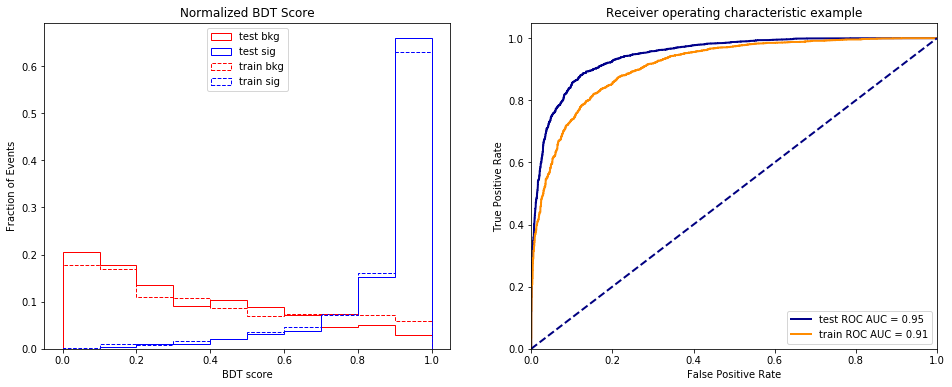

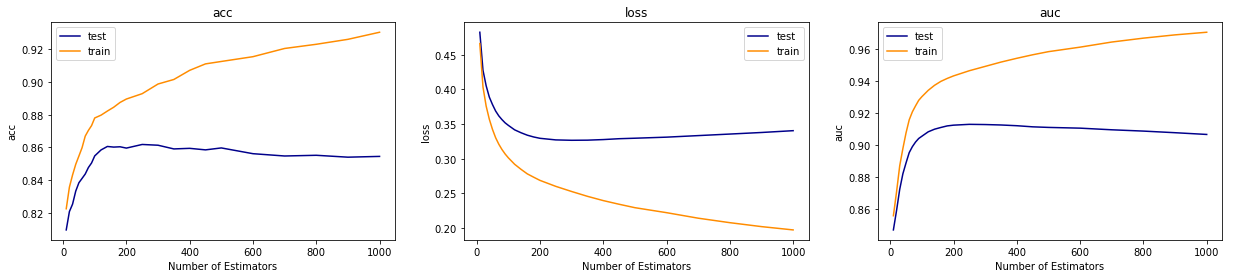

In [16]:
# Now plot everything we have for our best estimator
PlotROCTemplate(best_test_DF, best_train_DF, best_y_score_test, best_y_score_train)

# Also plot our parameter sweep
PlotBehavior(x, results_train, results_test, plot_err=False)

Now let us improve our training/testing split! Instead of just splitting our set, let us use KFold cross-validation.
We will split the set into N/k sized splits, which we will then permute k times into training and testing sets, never allowing the sets to overlap.

In [17]:
# Results will be stored as lists of pairs (mean, std) for each hyperparameter set
kfold_results_train = {"loss":[], "acc": [], "auc": []}
kfold_results_test = {"loss":[], "acc": [], "auc": []}

# Instead of a simple split, we here initialize a StratifiedKFold object to shuffle and split
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# While sweeping our hyperparameters, we want to track the best result for plotting in the end
best_score = -999

# Select some values of n_estimators to check, and lock the other hyperparameters
max_depth = 3
min_child_weight = 5
# Estimators to check -- the x axis of our plots
x = range(10,100,10) + range(100,200,20) + range(200,500,50) + range(500,1100,100)
for i,n_est in enumerate(x):
    
    # Lazy progress bar
    print "{:4s}".format(str(n_est)),
    
    # We will now have k results per set of hyperparameters, to average in the end
    this_result_train = {"loss":[], "acc": [], "auc": []}
    this_result_test  = {"loss":[], "acc": [], "auc": []}
    
    for train_index, test_index in skf.split(DF, DF["isSignal"]):


        train_DF = DF.iloc[train_index]
        test_DF = DF.iloc[test_index]    
        
        y_score_train, y_score_test = TrainEval(train_DF, 
                                                test_DF, 
                                                var_list, 
                                                n_estimators=n_est, 
                                                max_depth=max_depth,
                                                min_child_weight=max_depth,
                                                seed=0)

        # Record all the goodies from this iteration for plotting later
        this_result_test["loss"].append(log_loss(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]))
        this_result_train["loss"].append(log_loss(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]))    
        this_result_test["acc"].append(accuracy_score(test_DF["isSignal"], (y_score_test+0.5).astype(int), sample_weight=test_DF["weight"]))
        this_result_train["acc"].append(accuracy_score(train_DF["isSignal"], (y_score_train+0.5).astype(int), sample_weight=train_DF["weight"]))    
        this_result_test["auc"].append(roc_auc_score(test_DF["isSignal"], y_score_test, sample_weight=test_DF["weight"]))
        this_result_train["auc"].append(roc_auc_score(train_DF["isSignal"], y_score_train, sample_weight=train_DF["weight"]))    
    
    # Replace our recorded lists with a mean and standard deviation pair
    kfold_results_test["loss"].append((np.mean(this_result_test["loss"]), np.std(this_result_test["loss"])) )
    kfold_results_train["loss"].append((np.mean(this_result_train["loss"]), np.std(this_result_train["loss"])) )
    kfold_results_test["acc"].append((np.mean(this_result_test["acc"]), np.std(this_result_test["acc"])) )
    kfold_results_train["acc"].append((np.mean(this_result_train["acc"]), np.std(this_result_train["acc"])) )
    kfold_results_test["auc"].append((np.mean(this_result_test["auc"]), np.std(this_result_test["auc"])) )
    kfold_results_train["auc"].append((np.mean(this_result_train["auc"]), np.std(this_result_train["auc"])) )
    
    # Using our chosen "best" metric, we will keep track of the best set of hyperparameters here
    # We could have a more advance metric for early stopping here, such as demanding a stop if 
    # the score doesn't improve n times in a row, or a minimum required improvement,
    # but for now we won't worry about it
    OT_dev = 100*(kfold_results_train["auc"][i][0] - kfold_results_test["auc"][i][0]) / kfold_results_test["auc"][i][0]
    if kfold_results_test["auc"][i][0] > best_score:
        best_score = kfold_results_test["auc"][i][0] # test[auc][n_estimators][mean]
        best_score_std = kfold_results_test["auc"][i][1] # test[auc][n_estimators][mean]    
        best_score_train = kfold_results_train["auc"][i][0] # test[auc][n_estimators][mean]
        best_score_train_std = kfold_results_train["auc"][i][1] # test[auc][n_estimators][mean]        
        print "New high (auc) score!: {:4.4f} +- {:4.4f} ; Overtraining error {:4.2f}%".format(best_score, best_score_std, OT_dev)
        best_train_DF = train_DF
        best_test_DF = test_DF
        best_y_score_train = y_score_train
        best_y_score_test = y_score_test
        best_params = {"n_estimators":n_est, "max_depth": max_depth, "min_child_weight": max_depth}
    else:
        print "Not improved: {:4.4f} +- {:4.4f} ; Overtraining error {:4.2f}%".format(kfold_results_test["auc"][i][0], kfold_results_test["auc"][i][1], OT_dev)
        
print "" # consequence of the lazy progress bar

# Numpy arrays are easier to manipulate than lists
for k in kfold_results_test.keys():
    kfold_results_test[k] = np.array(kfold_results_test[k])
    kfold_results_train[k] = np.array(kfold_results_train[k])

10   New high (auc) score!: 0.8440 +- 0.0042 ; Overtraining error 1.29%
20   New high (auc) score!: 0.8611 +- 0.0035 ; Overtraining error 1.49%
30   New high (auc) score!: 0.8718 +- 0.0034 ; Overtraining error 1.72%
40   New high (auc) score!: 0.8832 +- 0.0036 ; Overtraining error 1.93%
50   New high (auc) score!: 0.8908 +- 0.0029 ; Overtraining error 2.09%
60   New high (auc) score!: 0.8956 +- 0.0034 ; Overtraining error 2.26%
70   New high (auc) score!: 0.8998 +- 0.0032 ; Overtraining error 2.39%
80   New high (auc) score!: 0.9028 +- 0.0031 ; Overtraining error 2.52%
90   New high (auc) score!: 0.9047 +- 0.0033 ; Overtraining error 2.68%
100  New high (auc) score!: 0.9064 +- 0.0029 ; Overtraining error 2.79%
120  New high (auc) score!: 0.9082 +- 0.0028 ; Overtraining error 3.01%
140  New high (auc) score!: 0.9096 +- 0.0024 ; Overtraining error 3.17%
160  New high (auc) score!: 0.9105 +- 0.0025 ; Overtraining error 3.32%
180  New high (auc) score!: 0.9111 +- 0.0024 ; Overtraining erro

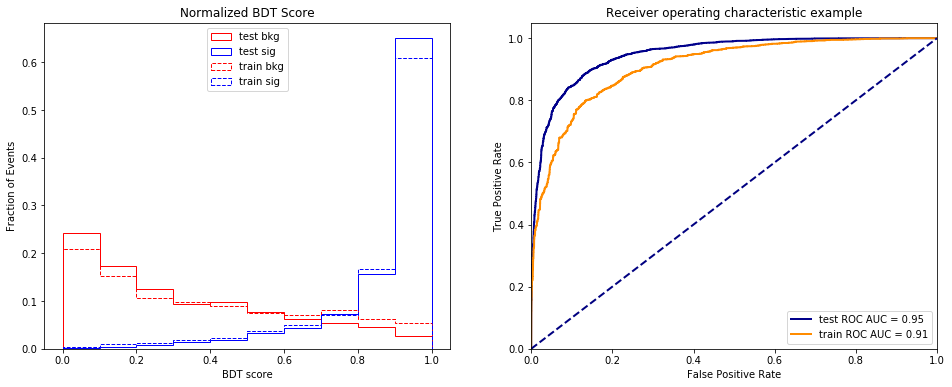

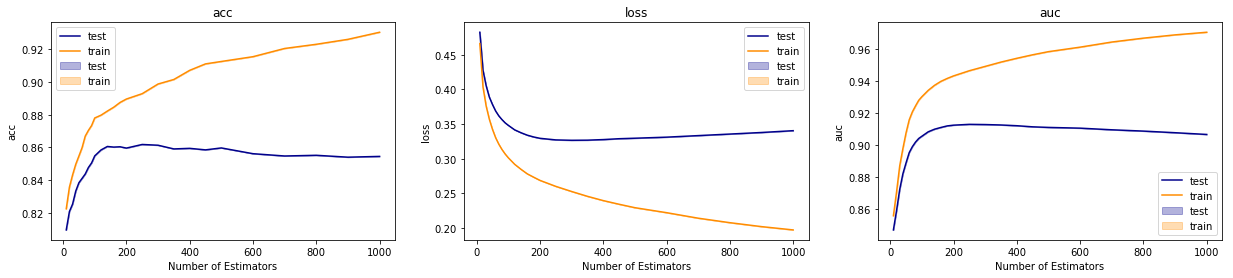

In [18]:
# Now plot everything we have for our best estimator
PlotROCTemplate(best_test_DF, best_train_DF, best_y_score_test, best_y_score_train)

# Also plot our parameter sweep
PlotBehavior(x, results_train, results_test, plot_err=True)